## Travelling Salesman Problem

<i>"Given a list of cities (nodes) and distances between each pair of cities (edges), what is the shortest possible route that visits each city and returns to the original city"</i>

### Packages

* **random** - For generating random numbers to be used as the nodes.
* **pandas** - Popular data analysis package in python
* **numpy** - Popular package in python for handling arrays 
* **pulp** - Optimization package that is used in one of the solutions
* **time** - Package used get time and calculate computational time.
* **matplotlib** - Used for plotting data 



In [1]:
import random
import pandas as pd
import numpy as np
import pulp
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Space

An object that generates nodes and stores metadata regarding said nodes. It also caclulates the distances between a pair of nodes and can show a plot of the nodes with a solution from an algorithm.

### Change self.permutations into {}

In [2]:
class Space():
    def __init__(self):
        self.nodes = {}
        self.solutions = {}
        self.solution_total_dist = {}
        self.distances = None
        self.nodes_df = None
        self.totalDistances = {}
        self.permutations = []
        
        
    def __len__(self):
        '''
        Returns the number of nodes available in the Space Object.
        '''
        
        return len(self.nodes)
    
    
    def posToChar(self,pos):
        '''
        Converts position (int) to a character starting with 'A'.
        
        pos: integer
        '''
        
        return chr(pos + 65) 
    
    
    def intToChar(self,inte):
        '''
        Converts integer into an only alphabet character string 
        starting with 'A'.
        
        inte: integer
        '''
        
        div = (inte//26)
        rem = inte%26
        
        if div == 0:
            return self.posToChar(rem)
        else:
            return self.posToChar(div-1) + self.posToChar(rem)
    
    
    def generateNodes(self,nums):
        '''
        Generates unique random cooordinates given a number of nodes.
        
        nums: integer
        '''
        
        assert len(self.nodes)==0,'Nodes already available'
        assert nums%1 == 0, 'Input not an integer. Try again.'
        assert nums>3,'Input must be greater than 3. Try again'
        
        num = 0
        while len(self)<nums:
            coordinates = random.sample(range(1,100), 2)
            if coordinates not in self.nodes.values():
                self.nodes[self.intToChar(num)] = coordinates
                num+=1

                
    def nodesToDF(self):
        '''
        Creates a pandas DataFrame od distance from dictionary of nodes.
        '''
        assert len(self.nodes)>0,'No nodes available.'
        
        self.nodes_df = pd.DataFrame(list(self.nodes.values())
                                     ,index=list(self.nodes.keys())) \
                                     .rename(columns = {0:'x',1:'y'})
        return self.nodes_df

        
    def getDistances(self):
        '''
        Converts dictionary of node coordinates into a table of distances
        '''
        
        #X's
        dfx = self.nodes_df['x']
        df1_x = pd.concat([dfx]*len(self), axis=1)
        df1_x.columns = df1_x.index
        df2_x = df1_x.T
        
        #Y's
        dfy = self.nodes_df['y']
        df1_y = pd.concat([dfy]*len(self), axis=1)
        df1_y.columns = df1_y.index
        df2_y = df1_y.T
        
        self.distances = (((df1_x-df2_x)**2) + ((df1_y-df2_y)**2))**(1/2)
        
        for i in self.distances.columns:
            for j in self.distances.index:
                self.totalDistances[(i,j)] = self.distances[i][j]
                
        self.distances = self.distances.replace(0,100)

        return self.distances
    
    
    def getDistance(self,order,end,total_distance):
        '''
        Outputs the distances from an input list. Uses memoization the store 
        previous calculations.
        
        order: tuple of node names in their respective order
        end: end of range to get distance
        total_distance: total distance (output)
        '''
        
        if end == len(order)+1:
            return total_distance
        
        elif order[:end] in self.totalDistances:
            total_distance = self.totalDistances[order[:end]]
            return self.getDistance(order,end+1,total_distance)
        else:
            total_distance = self.totalDistances[order[:end-1]] + \
                             self.distances[order[end-2]][order[end-1]]
            self.totalDistances[order[:end]] = total_distance
            
            return self.getDistance(order,end+1,total_distance)

        
    def getTotalDistance(self,order,solution_key=None):
        '''
        Outputs the total distances including the closing connection. Stores 
        output in solution_total_dist dictionary under the solution_key.
        
        order: order of nodes to calculate
        solution_key: name of this order
        '''
        
        order = tuple(order)
        self.total_distance = self.getDistance(order,2,0)
        self.total_distance += self.distances[order[-1]][order[0]]
        
        if solution_key is not None:
            self.solution_total_dist[solution_key] = self.total_distance 
            
        return self.total_distance
        
        
    def plot(self,solution_key,kind):
        '''
        Plots all nodes and edges (depending on solution_key) in space.
        
        solution_key: name of solution
        kind: 'char' - only shows node name
              'coor' - only shows coordinates of node
              'both' - shows both name and coordinates of nodes
        '''
        
        solution_total_dist = str(np.round(self.solution_total_dist[solution_key]
                                           ,2)) 
        
        fig, ax = plt.subplots(figsize=(10,10))
        self.nodes_df.plot(kind='scatter', 
                           x='x', y='y',
                           title=str(solution_key) +': '+ solution_total_dist, 
                           grid=True,
                           fontsize=10, 
                           ax=ax,
                           xlim = (0,100),
                           ylim=(0,100)) 
        
        for i in range(-1,len(self.solutions[solution_key])-1):
            j = self.solutions[solution_key][i]
            k = self.solutions[solution_key][i+1]
            
            ax.plot((self.nodes[j][0],self.nodes[k][0]),
                    (self.nodes[j][1],self.nodes[k][1]), 'r--')

            if kind == 'char':
                ax.annotate(j, (self.nodes[j][0],self.nodes[j][1]))
            elif kind == 'coor':
                ax.annotate((self.nodes[j][0],self.nodes[j][1]), 
                            (self.nodes[j][0],self.nodes[j][1]))
            elif kind == 'both':
                ax.annotate(str(j)+ ': ' + str((self.nodes[j][0],self.nodes[j][1])),
                           (self.nodes[j][0],self.nodes[j][1]), 
                            (self.nodes[j][0],self.nodes[j][1]))
            
            dist = int(self.distances[j][k])
            x = (self.nodes[j][0]+self.nodes[k][0])/2
            y = (self.nodes[j][1]+self.nodes[k][1])/2
            ax.annotate(dist, (x,y),color='green')    
            


In [3]:
S = Space()

In [4]:
S.generateNodes(6)

In [5]:
S.nodes

{'A': [60, 6],
 'B': [86, 40],
 'C': [25, 9],
 'D': [25, 80],
 'E': [87, 88],
 'F': [52, 41]}

In [6]:
S.nodesToDF()

,x,y
C,25,9
B,86,40
E,87,88
D,25,80
A,60,6
F,52,41


In [7]:
S.getDistances()

,C,B,E,D,A,F
C,100.000000,68.425142,100.424101,71.000000,35.128336,41.868843
B,68.425142,100.000000,48.010416,72.945185,42.801869,34.014703
E,100.424101,48.010416,100.000000,62.513998,86.330759,58.600341
D,71.000000,72.945185,62.513998,100.000000,81.859636,47.434165
A,35.128336,42.801869,86.330759,81.859636,100.000000,35.902646
F,41.868843,34.014703,58.600341,47.434165,35.902646,100.000000


### Algorithms

Parent class of the algorithms with different advantages and disadvantages.

In [8]:
class Algorithm(object):
    '''
    Parent class of all solutions
    '''
    def __init__(self):
        self.time = None
        
    def checkSpace(self,obj):
        assert isinstance(obj,Space),'Input must be Space object'
    
    def solveWithTimer(self,Space,verbose=False):
        '''
        Input space and saves time in time variable.
        '''
        start = time.time()
        solution = self.solve(Space,verbose)
        end = time.time()
        self.time = end - start
        

### Naive

First algorithm is the brute force solution which has two parts. First part is a recursive function that gets all permutations of the sequence of nodes. The second part is calculating the total distance for each sequence while finding the sequence with lowest total distance.

***O(n!) *** 

In [9]:
class Naive(Algorithm):
    def __str__(self):
        return "Naive"
    
    def permutation(self, order): 
        '''
        Recursive function that returns a list of all permutations of input.
        '''
        if len(order) == 0: 
            return [] 

        if len(order) == 1: 
            return [order] 

        current = [] 

        for i in range(len(order)): 
            m = order[i] 

            remaining = order[:i] + order[i+1:] 

            for p in self.permutation(remaining): 
                current.append([m] + p) 
                
        return current 

    
    def getPermutations(self, Space):
        '''
        We will be only using sequences that have the same first element 
        so that all the solutions will have the same starting and end node.
        By doing this we are reducing the total number of permutations 
        by the number of nodes (N! permutations to N!/N permutations). 
        To do this, we will only calculates the permutations from the 2nd
        node and retain the same first node.
        
        '''
        
        node_names = list(Space.nodes.keys())
        first = node_names.pop(0)
        
        Space.permutations = self.permutation(node_names)
        
        for i in range(len(Space.permutations)):
            Space.permutations[i].insert(0,first)
            
        return Space.permutations

    
    def getBest(self, Space, verbose):
        '''
        Loops through all permutations and finds the permutation that 
        has the least distance.
        
        verbose: Boolean, show log or not
        '''
        lowest = 10000000 
        lowest_perm = []
        total = 0
        
        if verbose == True:
            print('Total Permutations: ', len(Space.permutations))
            print()
        
        for perm in Space.permutations:
            perm_dist = Space.getTotalDistance(tuple(perm),'Naive')

            if lowest > perm_dist:
                if verbose == True:
                    
                    print('lowest: ',lowest)
                    print('lowest_perm: ',lowest_perm)
                    print()
                lowest = perm_dist
                lowest_perm = perm
                
            total += perm_dist
        
        Space.getTotalDistance(tuple(lowest_perm),'Naive')
        if verbose == True:
            print('total distance of all solutions: ',total)
        
        Space.solution_total_dist['Average'] = total/len(Space.permutations)
        if verbose == True:
            print('average distance of any solution: ',
                  Space.solution_total_dist['Average'])
        
        
        if verbose == True:
            print(Space.solution_total_dist['Naive'])
            
        return lowest_perm
    
    
    def solve(self, Space, verbose=True):
        '''
        Brute force solution
        
        verbose: Boolean, show log or not
        '''
        self.checkSpace(Space)
        
        self.permutations = self.getPermutations(Space)
        naive_solution = self.getBest(Space,verbose)
        
        Space.solutions['Naive'] = naive_solution
        Space.getTotalDistance(Space.solutions['Naive'],'Naive')
        
        

Hashset of distances for memoization

In [10]:
len(S.totalDistances)

36

In [11]:
N = Naive()
N.solve(S)

Total Permutations:  120

lowest:  10000000
lowest_perm:  []

lowest:  338.58068048318677
lowest_perm:  ['C', 'B', 'E', 'D', 'A', 'F']

lowest:  297.41470273226514
lowest_perm:  ['C', 'B', 'E', 'D', 'F', 'A']

lowest:  286.57009895490535
lowest_perm:  ['C', 'D', 'E', 'B', 'F', 'A']

total distance of all solutions:  42588.486697360684
average distance of any solution:  354.90405581133905
277.75762696099065


Hashmap has increased its length

In [12]:
len(S.totalDistances)

356

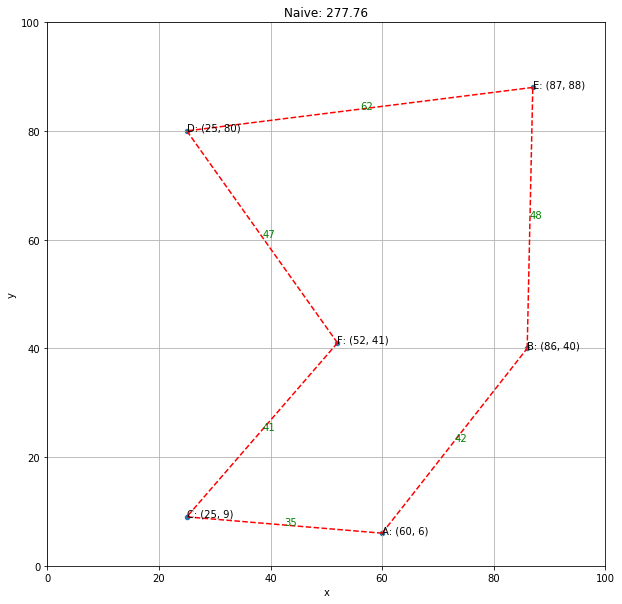

In [13]:
S.plot('Naive','both')

### Greedy

Finds whats the best decision momentarily but may not necesarily be the best results in the overall structure of the problem. This strategy does not get the most optimal solution however it is extremely fast.

***O(n^2) to O(n)***  Getting min is O(n) * total number of nodes (n),  but n is decreasing

In [14]:
class Greedy(Algorithm):
    def __str__(self):
        return "Greedy"
    
    def getMinRowCol(self, df):
        '''
        Get minimum distance value between any two nodes in the Dataframe
        
        df: pandas dataframe of distances from col name to row index or vice versa.
        '''
        row, col = df.stack().idxmin()
        return row,col

    def solve(self, Space, verbose=True):
        '''
        Gets minimum distance value between any two nodes and then finds the 
        least distance to the next node for every succeeding nodes.
        
        verbose: Boolean, show log or not
        
        '''
        
        self.checkSpace(Space)
        
        visited_list = list()

        row,col = self.getMinRowCol(Space.distances)
        latest = col
        visited_list.append(row)
        visited_list.append(latest)
        
        if verbose == True:
            print('minimum distance from any two nodes:')
            print(str(row) + ' to ' + str(col) + ': ' + \
                  str(Space.distances[row][col]))
            print('')
            print('minimum distance following prev node:')
                
        for i in range(len(Space.distances.columns)-2):
            latest = Space.distances.drop(visited_list).idxmin()[latest]
            visited_list.append(latest)
            if verbose == True:
                print(str(visited_list[-2]) 
                      + ' to ' 
                      + str(visited_list[-1]) 
                      + ': ' 
                      + str(Space.distances[visited_list[-2]][visited_list[-1]]))
                
        Space.solutions['Greedy'] = visited_list    
        Space.getTotalDistance(Space.solutions['Greedy'],'Greedy')
        


In [15]:
G = Greedy()

In [16]:
G.solve(S)

minimum distance from any two nodes:
B to F: 34.0147027033899

minimum distance following prev node:
F to A: 35.90264614203248
A to C: 35.12833614050059
C to D: 71.0
D to E: 62.51399843235114


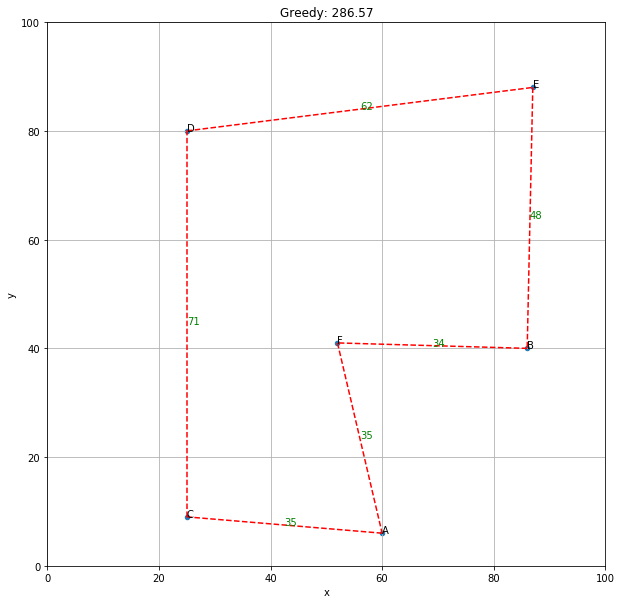

In [17]:
S.plot('Greedy','char')

### Optimization: Integer Programming

Integer programming is when you minimize/maximize an objective function by adjusting its the weights which can only be integers. Constraints are the different rules that has to be followed in the optimization process. In this application, we put weights (0 or 1) on each edge and that will be our objective function. As for the constraints we have two: 

* Only one path can exit each node
* Only one path can enter each node

Given that we optimize using the above constraints, we will encounter the issue of subtours. This is when the solution is only locally connected (ie (A->B),(B->A),(C->D),(D->C)). To rectify this, we will more add contstraints that are specific to each subtour (ie (A->B) + (B->A) <= 1) and optimize again. As we add constraints that eliminates subtours, it is likely that more subtour will emerge. We will keep repeating this process until all subtours are eliminated then we will have an optimal solution.



In [18]:
class Optimization(Algorithm):
    def __str__(self):
        return "Optimization"
    
    
    def solutionToTuple(self, model):
        '''
        model: pulp object
        '''
        output = []
        for v in model.variables():
            if v.varValue>0:
                name = v.name[5:]
                r = name[name.rfind('_to_')+4:]
                l = name[:name.rfind('_to_')]
                output.append((l,r))
                
        return output


    def identifySubtourFromTuples(self, Space, list_of_tuples):
        '''
        Outputs a list of subtours from list a list of touples
        
        list_of_tuples: list of tuples where 0th index of each tuple is the 
        starting node and the 1st index is the end node. Each tuple represents 
        an edge.  
        
        '''
        subtours = []
        subtour = []

        i = 0

        while len(list_of_tuples)>0:
            next_node = list_of_tuples[i][1]
            subtour.append(list_of_tuples[i])
            list_of_tuples.pop(i)
            j = 0
            subtour_end = False
            while subtour_end == False:
                j = 0
                while (j < len(list_of_tuples)):
                    if next_node == list_of_tuples[j][0]:
                        subtour.append(list_of_tuples[j])
                        next_node = list_of_tuples[j][1]
                        list_of_tuples.pop(j)
                        j = 0
                        break
                    j += 1

                if j == len(list_of_tuples):
                    subtour_end = True

            subtours.append(subtour)
            subtour = []
            
        return subtours

    
    def getColInd(self,node_tuple,Space):
        '''
        Input a tuple of node names and returns the row and column index
        
        node_tuple: tuple of two nodes that signify an edge
        '''
        col = list(Space.distances.columns).index(node_tuple[0])
        row = list(Space.distances.index).index(node_tuple[1])
        
        return col,row
    
    
    def addNewConstraints(self,Space,subtours):
        '''
        Adds new contraints to eliminate subtours
        
        subtours: list of subtours
        '''
        new_constraints = []
        for subtour in subtours:
            new_constraint = np.zeros(Space.distances.shape)
            for node in subtour:
                row,col = self.getColInd(node,Space)
                new_constraint[row][col] = 1
            new_constraints.append(new_constraint.flatten())
            
        return new_constraints
    
    
    def tupleToSolution(self,subtours):#subtourToSolution
        '''
        Converts list tuples into solution format
        '''
        solution = []
        for subtour in subtours[0]:
            solution.append(subtour[0])

        return solution
    
    
    def solve(self,Space,verbose=True):
        '''
        Solve using integer programming. Iteratively adds more constraints 
        until an acceptable solution is found.
        '''
        
        self.checkSpace(Space)
        
        constraint = np.zeros([len(Space), len(Space)**2])

        constraint1 = constraint.copy()#only one edge enter one node
        constraint2 = constraint.copy()#only one path that exit one node
    
        for i in range(len(Space)):
            constraint1[i][i*len(Space):(i+1)*len(Space)] += 1
        for i in range(len(Space)):
            constraint2[:,(i)*len(Space):(i+1)*len(Space)] += \
            np.identity(len(Space))
        

        constraints = np.concatenate([constraint1,constraint2],axis=0)

        model = pulp.LpProblem("TSP", pulp.LpMinimize)

        path_names = []

        for i in Space.distances.columns:
            for j in Space.distances.index:
                path_names.append(i + ' to ' + j)

        costs = []

        for row in Space.distances:
            costs.extend(Space.distances[row].values)

        costs_dict = dict(zip(path_names,costs))

        path_vars = pulp.LpVariable.dicts("path", path_names,
                                          lowBound=0, cat='Integer')

        model += pulp.lpSum([costs_dict[i]*path_vars[i] for i in path_names])

        for i in range(constraints.shape[0]):
            model += pulp.lpSum([constraints[i][j] * path_vars[path_names[j]] for j in range(len(path_names))]) >= 1, "constraints_"+str(i)
        
        if verbose == True:
            print(model)

        tsp_iteration = 0
        num_subtour = 1000

        while (num_subtour>1):
            model.solve()
            if verbose == True:
                print()
                print()
                print("Status:", pulp.LpStatus[model.status])
                print('TSP iteration: ', tsp_iteration)
                print('total distance: ', str(pulp.value(model.objective)))

            solution = []
            for v in model.variables():
                solution.append(v.name)

            list_of_tuples = self.solutionToTuple(model)

            subtours = self.identifySubtourFromTuples(Space,list_of_tuples)
            num_subtour = len(subtours)
            if verbose == True:
                print('subtours: ')
                for subtour in subtours:
                    print(subtour)
                print()

            new_constraints = self.addNewConstraints(Space,subtours)

            tsp_iteration += 1
            new_constraint_names = []
            for i in range(len(new_constraints)):
                new_constraint_name = "subtour_constraints_" + str(tsp_iteration) + '_'+str(i) 
                new_constraint_names.append(new_constraint_name)
    
                model += pulp.lpSum([new_constraints[i][j] * path_vars[path_names[j]] for j in range(len(path_names))]) <= sum(new_constraints[i])-1, new_constraint_name
            
            if verbose == True:
                print('new constraints: ',len(model.constraints))
                for constraint_name in new_constraint_names:
                    print(model.constraints[constraint_name])
                
                print('===============================================================================')
                print()

        if verbose == True:
            print('total distance: '+str(pulp.value(model.objective)))
            for subtour in subtours:
                    print(subtour)
                    
        Space.solutions['Optimization'] = self.tupleToSolution(subtours)
        Space.getTotalDistance(Space.solutions['Optimization'], 'Optimization')


    

In [19]:
O = Optimization()

In [20]:
O.solve(S)

TSP:
MINIMIZE
100.0*path_A_to_A + 42.80186911806539*path_A_to_B + 35.12833614050059*path_A_to_C + 81.85963596303125*path_A_to_D + 86.33075929238663*path_A_to_E + 35.90264614203248*path_A_to_F + 42.80186911806539*path_B_to_A + 100.0*path_B_to_B + 68.42514157822401*path_B_to_C + 72.94518489934754*path_B_to_D + 48.010415536631214*path_B_to_E + 34.0147027033899*path_B_to_F + 35.12833614050059*path_C_to_A + 68.42514157822401*path_C_to_B + 100.0*path_C_to_C + 71.0*path_C_to_D + 100.42410069301094*path_C_to_E + 41.86884283091664*path_C_to_F + 81.85963596303125*path_D_to_A + 72.94518489934754*path_D_to_B + 71.0*path_D_to_C + 100.0*path_D_to_D + 62.51399843235114*path_D_to_E + 47.43416490252569*path_D_to_F + 86.33075929238663*path_E_to_A + 48.010415536631214*path_E_to_B + 100.42410069301094*path_E_to_C + 62.51399843235114*path_E_to_D + 100.0*path_E_to_E + 58.60034129593445*path_E_to_F + 35.90264614203248*path_F_to_A + 34.0147027033899*path_F_to_B + 41.86884283091664*path_F_to_C + 47.43416490252

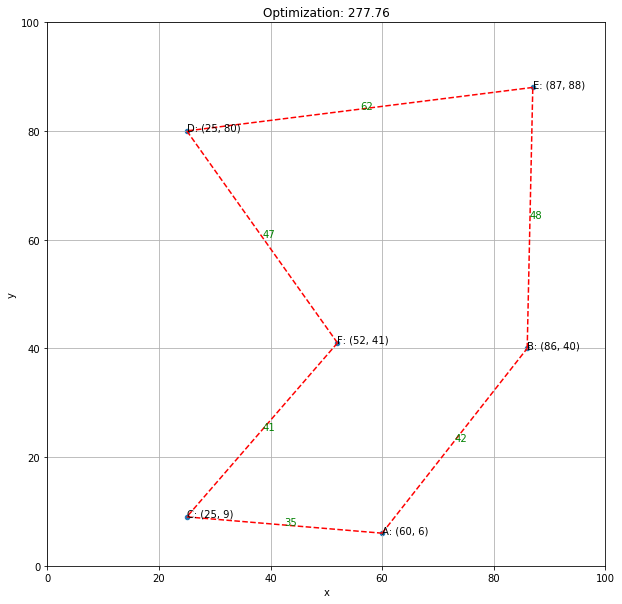

In [21]:
S.plot('Optimization','both')

In [22]:
def benchmark(low,high,step=1,include_naive=True):
    '''
    Plots computational time of different algorithms and their accuracies given a range.
    
    low: lower bound of range to compute
    high: upper bound of range to compute
    '''
    
    time_df = pd.DataFrame()
    dist_df = pd.DataFrame()
    

    for i in range(low,high,step):
        print('Calculating with Nodes:', i)
        S = Space()
        S.generateNodes(i)
        S.nodesToDF()
        S.getDistances()
        
        algorithms = []
        for cls in Algorithm.__subclasses__():
            if str(cls.__name__) == 'Naive':
                if include_naive == True:
                    algorithms.append(cls())
                else:
                    pass
            else:
                algorithms.append(cls())

        for algorithm in algorithms:
            algorithm.solveWithTimer(S)
        
        time_dict = {}
        dist_dict = {}
        for algorithm in algorithms:
            time_dict[str(algorithm)] = [algorithm.time]
            dist_dict[str(algorithm)] = [S.solution_total_dist[str(algorithm)]]
            
        if include_naive == True:
            dist_dict['Average'] = [S.solution_total_dist['Average']]
        
        time_df = time_df.append(pd.DataFrame(data = time_dict,index = [i]))
        dist_df = dist_df.append(pd.DataFrame(data = dist_dict,index = [i]))
        
        
    axes = ()*len(algorithms)
    fig,axes  = plt.subplots(1,len(algorithms))
    fig.suptitle('Computational Time')
    fig.legends
    fig.set_figwidth(15)

    counter = 0
    for ax in axes:
        ax.plot(time_df[str(algorithms[counter])])
        ax.legend(loc="upper right")
        ax.set_xlabel('Num of Nodes')
        ax.set_ylabel('Time (Sec)')
        counter +=1

    
    if include_naive == True:
        bench = "Naive"
    else:
        bench = "Optimization"
        
    bench_df = dist_df[bench]
    dist_df = dist_df.subtract(dist_df[bench], axis=0)
    dist_df = dist_df.div(bench_df, axis=0)
    dist_df.drop(bench, axis=1, inplace=True)
    dist_df.plot(kind='line', title='Percent Error vs ' + str(bench), ylim=(-.1,1.1), figsize=(12,4))
        
    del algorithms

Calculating with Nodes: 4
Calculating with Nodes: 5
Calculating with Nodes: 6
Calculating with Nodes: 7
Calculating with Nodes: 8
Calculating with Nodes: 9
Calculating with Nodes: 10


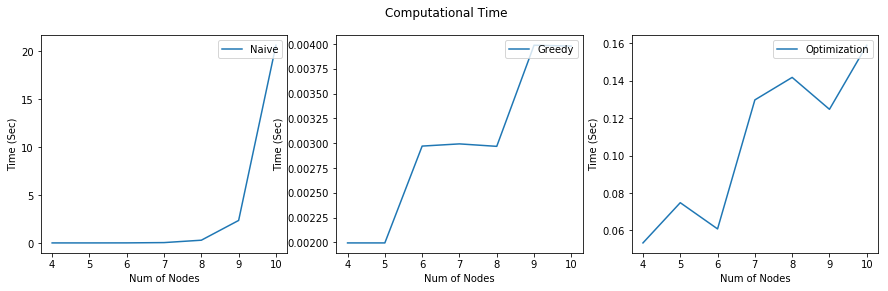

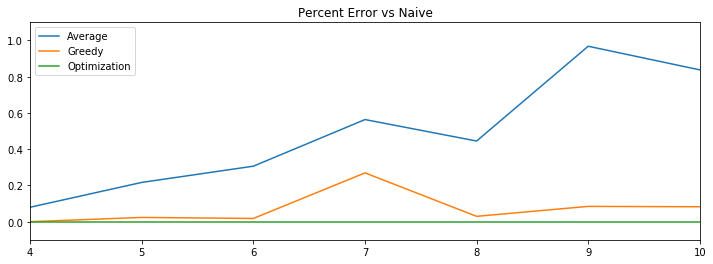

In [23]:
benchmark(4,11)

Calculating with Nodes: 10
Calculating with Nodes: 15
Calculating with Nodes: 20
Calculating with Nodes: 25
Calculating with Nodes: 30
Calculating with Nodes: 35


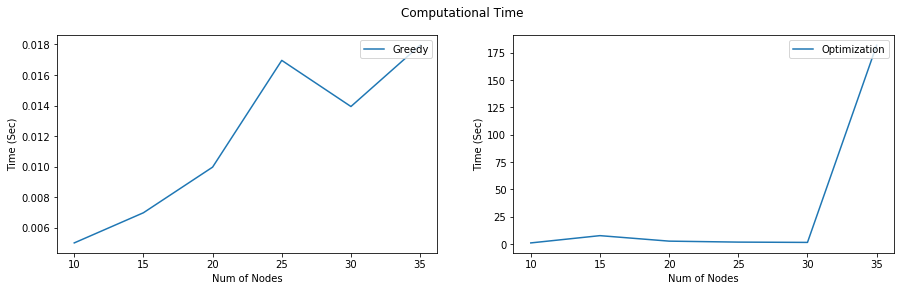

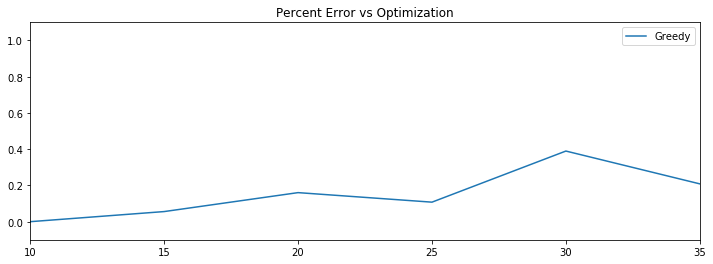

In [24]:
benchmark(10,40,5,False)